In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import matplotlib
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation          import received_power, propagation_delay
from parametermeasurement import measure_range_bechadergue_dflipflop, measure_range_bechadergue_counter
from simulation           import Simulation, generate_simulation_clocks

### Define full simulation run as a function

In [2]:
def simulation_run(weather, daynight, iterations):
    ### world parameters
    sim = Simulation(weather        = weather, 
                     temperature    = 298,   # [K], circuit temperature
                     daynight       = daynight, 
                     rxconfig       = "optics/qrx_planoconvex.npz", 
                     txconfig       = "optics/tx_lambertian_20deg_2W.npz", 
                     istxlambertian = True, 
                     f_adc_clk      = 1.0e7,  # [Hz] ADC measurement clock freq
                     f_e            = 1.0e6,  # [Hz] emitted wave freq, left TX
                     f_sim          = 1.0e10) # [Hz] simulation master clock freq

    ### bechadergue-specific algorithm parameters
    becha_f_dig_clk = 1e8;   # [Hz], bechadergue digital counter clock freq
    becha_r         = 5000;  # unitless, heterodyning factor
    becha_N         = 4;     # unitless, averaging factor for left TX

    ### bechadergue-specific timing parameters 
    # The time resolution of the simulation clock determines the minimum spatial resolution 
    # representable on the received signal, i.e., 1 tick on the simulation clock corresponds 
    # to x cm light travel distance. 
    sim_res         = sim.lightspeed / sim.f_simulation; # [m]
    f_gate          = sim.f_emitted * (1 / (becha_N * (becha_r+1) ) )
    t_gate_pulse    = (1/f_gate)/2
    t_sim_stop      = t_gate_pulse*1.05; # stretch by 5 percent to ensure capturing gate pulse

    ### list of coordinate points to test (this is a test-track simulation, not a trajectory)
    # the testing points, i.e., range values, need to be decimated according to simulation spatial 
    # resolution for meaningful results, so quantize them accordingly. When $d_{min}$=spatial resolution, 
    # deterministic quantization error is also prevented. Since there's also no heterodyning error here 
    # (see plotted gate pulse graph below, we always align the simulation time windows for each testing point separately), 
    # this simulation only considers the statistical effects arising from channel noise. 
    range_start = 01.00
    range_stop  = 20.00
    
    range_decimation_factor = 50; # no need to go through all of them, standard deviation will evolve smoothly anyhow
    quantization_factor = sim_res
    
    rg = np.linspace(range_start, range_stop, int((range_stop-range_start)/(range_decimation_factor*quantization_factor))+1)
    rg = (quantization_factor)*np.round(rg/quantization_factor)
    
    x = np.zeros(rg.shape[0]);
    
    hdg = np.zeros(rg.shape[0]); # parallel vehicles

    ### generate simulation clocks
    # generate simulation and adc clock signals
    # Note that minimum simulation resolution is not the resolution of the auto-digital method ($d_{min}$), 
    # but for meaningful simulations, we need to make sure that the minimum spatial resolution of the simulation 
    # is at least equal to $d_{min}$. Also, note that the output of the auto-digital method can go to higher precision 
    # using the averaging factor $N$.
    s_simulation, s_adc_re = generate_simulation_clocks(t_sim_stop, sim.f_simulation, sim.f_adc_clock)
    del s_simulation # to relieve memory since we'll regenerate it just below
    
    # bechadergue's method needs an extra digital clock
    s_simulation, s_dig_re = generate_simulation_clocks(t_sim_stop, sim.f_simulation, becha_f_dig_clk)

    ### simulate received power
    pwr   = received_power(x, rg, np.zeros_like(rg), sim.rx_config_bundle["pd_dimension"]/1000, hdg, sim)
    delay = propagation_delay(x, rg, sim.lightspeed)

    ### pre-compute the quantities that do not change over the test track to save on simulation time, these are:
    # - $s_e$: first transmitted signal (logic, sim time)
    # - $s_{e,sin}$: same as $s_e$, but used for the DFT-based method so no zero-crossing detection 
    #                necessary + it's clocked, so (sin, clocked)
    # - $s_h$: heterodyning signal (logic, sim time)
    # - $s_{gate}$: generated in sim time as a sine wave, then zero-crossing converts it to a logic signal, 
    #               and then it's clocked, so (logic, clocked)

    # np/32 to shift the gate start signal a bit to catch the whole period (see below)
    s_h    = np.sin(2*np.pi* sim.f_emitted*(becha_r/(becha_r+1))*s_simulation - np.pi/32)>0;
    s_e    = np.sin(2*np.pi* sim.f_emitted*s_simulation - np.pi/32)>0;
    s_eh   = measure_range_bechadergue_dflipflop(s_e, s_h)[s_dig_re]
    s_gate = np.sin(2*np.pi* sim.f_emitted*(1/(becha_N*(becha_r+1))) *s_simulation - np.pi/32)>0;
    s_gate = s_gate[s_dig_re]
    
    # np/32 to shift the gate start signal a bit to catch the whole period (see below)
    s_e_sin = np.sin(2*np.pi* sim.f_emitted *s_simulation[s_adc_re] - np.pi/32);
    s_e_sin = sp.fft.fft(s_e_sin);
    s_e_sin[0:int(s_e_sin.shape[0]/2)] = 0;
    s_e_sin = sp.fft.ifft(s_e_sin);

    ## uncomment this if you want to see the gate pulse mentioned above.
    # print("for each location on the test track, we measure estimations produced for one gate pulse:")
    # print("")
    # fig, ax = plt.subplots(figsize=(4, 2), dpi=80)
    # ax.plot(s_gate)
    # ax.grid()
    # plt.show()
    # print("")

    ### njit-ed functions to speed up simulation
    @njit(parallel=True, fastmath=True)
    def gen_rx(rx_peakAmps, f, s_simulation, delay, rx_noise_stdev, noise, pd_gain):
        return (rx_peakAmps*(np.sin(2*np.pi*f*(s_simulation - 2*delay) - np.pi/32)) / 2 + rx_noise_stdev * noise)*pd_gain;
    
    @njit(parallel=True, fastmath=True)
    def s_r_zc(s_r_sin):
        return s_r_sin > 0;
    
    @njit(parallel=True, fastmath=True)
    def gen_noise(s_sim_shape):
        return np.random.randn(s_sim_shape);

    ### run simulation over the list of points
    d_bec = np.zeros((iterations, x.shape[0]))
    d_rob = np.zeros((iterations, x.shape[0]))
    
    for j in tqdm(range(0, iterations)):
        ns = gen_noise(s_simulation.shape[0]);
        for i in range(0, rg.shape[0]):
            delay          = rg[i]/sim.lightspeed
            rx_peakAmps    = pwr[i]*sim.rx_config_bundle["pd_sensitivity"]
            rx_noise_stdev = np.sqrt(sim.bwscaling*sim.rx_config_bundle["rx_P_rx_factor"]*pwr[i] + \
                                     sim.rx_config_bundle["thermal_and_bg_curr"]);         
            
            s_r_sin = gen_rx(rx_peakAmps, sim.f_emitted, s_simulation, delay, rx_noise_stdev, ns, sim.rx_config_bundle["pd_gain"])
            
            ### roberts
            s_r_f = sp.fft.fft(s_r_sin[s_adc_re]);
            s_r_f[0:int(s_r_f.shape[0]/2)] = 0;
            s_r_f = sp.fft.ifft(s_r_f);
            
            phase_shift_diff_est = np.mean(np.angle(s_e_sin * np.conjugate(s_r_f)));
            del s_r_f
            d_rob[j,i] = sim.lightspeed*(phase_shift_diff_est/(2*np.pi*2*sim.f_emitted))       
            
            ### bechadergue
            s_r = s_r_zc(s_r_sin)
            del s_r_sin
            s_rh = measure_range_bechadergue_dflipflop(s_r, s_h)[s_dig_re]
            del s_r
            s_phi    = np.logical_xor(s_eh, s_rh);
            s_phi_pp = s_phi*s_gate # clock applied implicitly with adc_clock_re
    
            count = measure_range_bechadergue_counter(s_phi_pp, s_gate)
            f_i = sim.f_emitted/(becha_r+1);
            phase_shift_est = 2*np.pi*(np.asarray(count)*f_i/(becha_N*becha_f_dig_clk))
            d_bec[j,i] = sim.lightspeed*(phase_shift_est/(2*np.pi*2*sim.f_emitted))

    return rg, d_bec, d_rob

### Run simulation for different weather conditions

In [3]:
rg, d_bec_clearnight, d_rob_clearnight = simulation_run("clear", "night", 100)
rg, d_bec_rainsun,    d_rob_rainsun    = simulation_run("rain", "day_directsun", 100)

100%|███████████████████████████████████| 100/100 [13:38<00:00,  8.19s/it]


### Plot

In [4]:
d_bec_clearnight_error = d_bec_clearnight - rg
d_rob_clearnight_error = d_rob_clearnight + rg # rob goes out as negative
d_bec_rainsun_error = d_bec_rainsun - rg
d_rob_rainsun_error = d_rob_rainsun + rg # rob goes out as negative

In [5]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

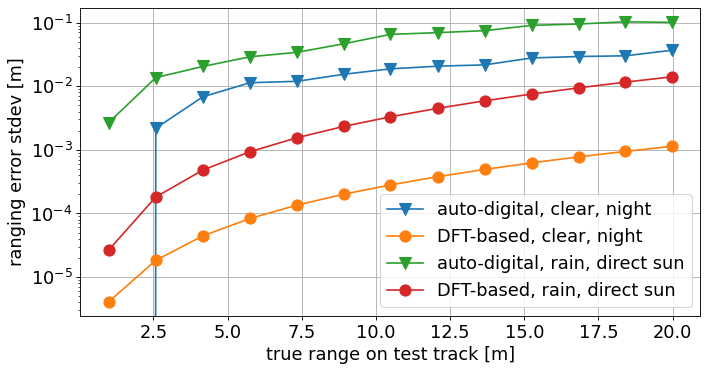

In [6]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=80)
ax.semilogy(rg, np.std(d_bec_clearnight_error, axis=0),'-v', markersize=10)
ax.semilogy(rg, np.std(d_rob_clearnight_error, axis=0),'-o', markersize=10)
ax.semilogy(rg, np.std(d_bec_rainsun_error, axis=0),'-v', markersize=10)
ax.semilogy(rg, np.std(d_rob_rainsun_error, axis=0),'-o', markersize=10)
ax.grid()
ax.legend(['auto-digital, clear, night', 
           'DFT-based, clear, night', 
           'auto-digital, rain, direct sun', 
           'DFT-based, rain, direct sun'])
plt.ylabel('ranging error stdev [m]')
plt.xlabel('true range on test track [m]')
plt.show()